In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import re
import requests

# TO TEST ?!?!
from nose.tools import *

# Blood Cells Feature Extraction
Given an image with a blood smear can we extract the separate cells? What about the different types of blood cells?

## Abstract
TODO: Describe the problem, procedures, and outcomes in short. Do this section last.
The count of blood cells is a widely used test to detect abnormalities and to diagnose different diseases.

## Introduction

The main task is trying to extract blood cells from a dataset with blood smears including various types of cells with different types, coloring, shapes, etc. The main dataset that we will use is https://mahmudulalam.github.io/Complete-Blood-Cell-Count-Dataset/. It contains 360 blood smear images but currently we will use only the Training folder with 300 images. Actually, the dataset includes annotations for the images but for now, we will try to segment and detect them using image processing tools.

### Short description of blood smears

<img src="https://askhematologist.com/wp-content/uploads/2016/02/blood-cells-300x214.jpg">

Major types of blood cells include:

| Major Cell Type| Main Function | Diameter | Specific characteristics|
| --- | --- | --- | --- |
| Red blood cells (erythrocytes) | carry oxygen | 6 - 8 μm. | oval biconcave disks (i.e. disc-shaped with a pale-staining central area) without a cell nucleus and most organelles|
| White blood cells (leukocytes) | immune system | 12 - 17 µm | have a clear nucleus; different types: neutrophils, eosinophils, basophils, lymphocytes, and monocytes |
| Platelets (thrombocytes) | initiate a blood clot | 2 – 3 µm in greatest diameter | very small, no nucleus |

Whole blood contains red cells, white cells, and platelets (45% of volume) suspended in blood plasma (55% of volume).


Now, let's try to look at a sample image from the dataset. But first, let's define a few help functions for reading an image from an url and plotting an image.

In [3]:
def read_image_by_url(url):
    """
    read an image by a given url containing an image
    """
    response = requests.get(url, stream = True).raw
    image = np.asarray(bytearray(response.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def plot_image(
    image, 
    title, 
    colour_map = "gray",
    show_figure = True,
    plot_axis = None):
    """
    shows an OPENCV image in BGR format with a given title
    @colour_map - it can be "gray" or "color"
    """
    
    ax = plot_axis
    if plot_axis == None:
        _, ax = plt.subplots()
        
    if colour_map == "color":
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
    elif colour_map == "gray":
        ax.imshow(image, cmap = colour_map)
    else:
        raise ValueError("The colour map must be either \"color\" or \"gray\"")
        
    ax.set_title(title)
    ax.axis("off")
    if show_figure:
        plt.show()    

Here is the URL containing the images of cells for the used dataset.

In [4]:
URL = "https://raw.githubusercontent.com/MahmudulAlam/Complete-Blood-Cell-Count-Dataset/master/Testing/Images/"

Let's look at a few sample images:

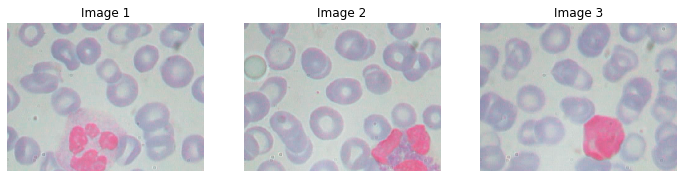

In [5]:
image1 = read_image_by_url(URL + "BloodImage_00346.jpg")
image2 = read_image_by_url(URL + "BloodImage_00345.jpg")
image3 = read_image_by_url(URL + "BloodImage_00347.jpg")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
plot_image(image1, "Image 1", plot_axis = ax1, show_figure = False)
plot_image(image2, "Image 2", plot_axis = ax2, show_figure = False)
plot_image(image3, "Image 3", plot_axis = ax3, show_figure = False)
plt.show()

## Segmentation

### Preprocessing
Usually the input images are not always clear enough and they need some initial preprocessing in order to improve contrast, eliminate noise if possible and generally improve the quality of the image. Also, it is a good idea to have some "standard" initial conditions in order to produce more accurate results with the further processing.

Here are the two main preprocessing techniques used:
- Histogram Equalization
- Filtering

In [6]:
def plot_image_colors_histogram(
    image,
    show_figure = True, 
    plot_axis = None):
    
    ax = plot_axis
    if plot_axis == None:
        _, ax = plt.subplots()
    
    ax.hist(image.flatten(), 256, [0, 256], color = 'g')
    ax.set_xlim([0, 256])
    ax.set_title("Colors distribution")   
    ax.set_xlabel("Color intensity levels [0, 255]")
    ax.set_ylabel("Number of pixels")
    
    if show_figure:
        plt.show()

#### Histogram Equalization
In the provided dataset, images have more specific range of values i.e. a little bit more brighter images. So most of the pixels have high values. We will try to have values from the whole grayscale spectrum. The idea is to improve the contrast of the image.

In [7]:
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

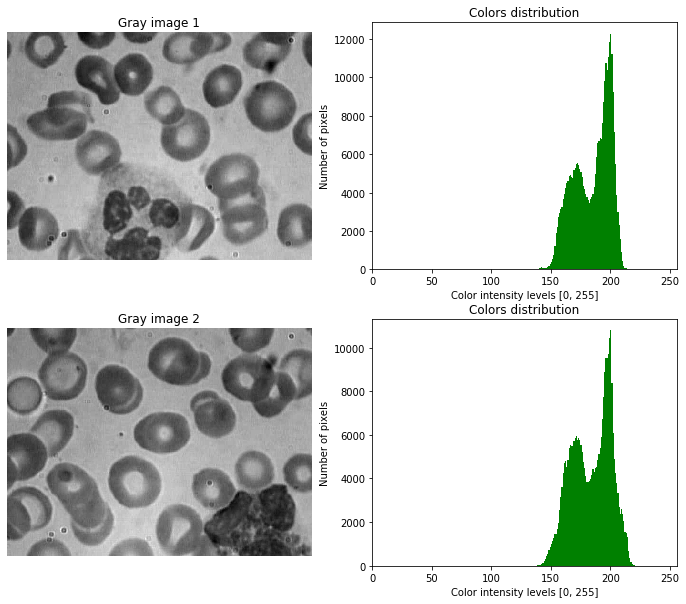

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
plot_image(gray_image1, "Gray image 1", plot_axis = ax1, show_figure = False)
plot_image_colors_histogram(gray_image1, plot_axis = ax2, show_figure = False)
plot_image(gray_image2, "Gray image 2", plot_axis = ax3, show_figure = False)
plot_image_colors_histogram(gray_image2, plot_axis = ax4, show_figure = False)
plt.show()

In [9]:
def normalize(image, new_min, new_max):
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) * (new_max - new_min)/(image_max - image_min) + new_min
    
def equalize_histogram(image):
    hist, bins = np.histogram(image1.flatten(), 256, [0,256])
    # [sum(h[:i+1]) for i in range(len(h))]
    cdf = np.cumsum(hist)
    
    # normalize cdf values between [0, 255]
    cdf_mask = np.ma.masked_equal(cdf, 0) # ignore zeroes
    cdf_mask = normalize(cdf_mask, 0, 255)
    normalized_cdf = np.ma.filled(cdf_mask, 0).astype('uint8')
    
    return normalized_cdf[gray_image1]
    

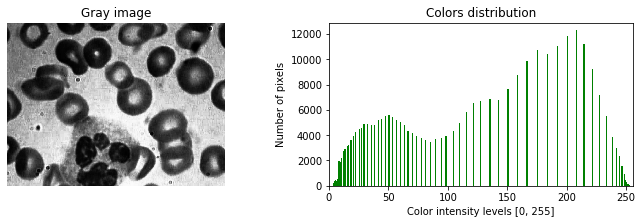

In [10]:
enhanced_image = equalize_histogram(gray_image1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
plot_image(enhanced_image, "Gray image", plot_axis = ax1, show_figure = False)
plot_image_colors_histogram(enhanced_image, plot_axis = ax2, show_figure = False)
plt.show()

Note:
Histogram equalization is good when histogram of the image is confined to a particular region. It won’t work good in places where there is large intensity variations where histogram covers a large region, ie both bright and dark pixels are present. 


### Image Segmentation

- extract all types of cells...

In [11]:
def normalize_colors(rgb):
    norm = np.zeros(rgb.shape, np.float32)
    
    b = rgb[:, :, 0]
    g = rgb[:, :, 1]
    r = rgb[:, :, 2]
    
    sum = b + g + r
    norm[:, :, 0] = b/(sum + (sum==0)) * 255
    norm[:, :, 1] = g/(sum + (sum==0)) * 255
    norm[:, :, 2] = r/(sum + (sum==0)) * 255
    
    norm_rgb = cv2.convertScaleAbs(norm)
    return norm_rgb

In [12]:
def find_cell_edges(image):
    #normalized_image = normalize_colors(image)
    #plot_image(normalized_image, "Normalised image")
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    plot_image(gray_image, "Gray image")
    
    equalized_image = cv2.equalizeHist(gray_image)
    plot_image(equalized_image, "Equalized image")
    
    smoothen_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)
    plot_image(smoothen_image, "Gaussian Blur")
    
    otsu_threshold, otsu_image = cv2.threshold(gray_image, 0, 255,
                                               cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    plot_image(otsu_image, "otsu")
    
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    image_closed_otsu = cv2.morphologyEx(otsu_image, cv2.MORPH_CLOSE, 
                                         structuring_element, iterations = 4)
    plot_image(image_closed_otsu, "Closed Otsu")
    
    canny_image = cv2.Canny(image_closed_otsu, otsu_threshold, 0.5*otsu_threshold)
    plot_image(canny_image, "canny edges")
    
    return canny_image

In [13]:
class Contour:
    
    def __init__(self, contour):
        self.contour = contour 
        
        area = cv2.contourArea(contour)
        (x, y), radius = cv2.minEnclosingCircle(contour)
        
        # the diameter of the circle whose area is same as the contour area
        equivalent_diameter = np.sqrt(4*area/np.pi)
        # enclosing circle
        enclosing_circle_center_x, enclosing_circle_center_y = (int(x), int(y))
        enclosing_circle_diameter = 2 * int(radius)
        
        self.contour_data = {
            "area": area,
            "equivalent_diameter": equivalent_diameter,
            "enclosing_circle_center_x": enclosing_circle_center_x,
            "enclosing_circle_center_y": enclosing_circle_center_y,
            "enclosing_circle_diameter": enclosing_circle_diameter}
        

In [14]:
def draw_contours_by_edges(image, image_edges):
    contours_with_data = []
    _, contours, _ = cv2.findContours(image_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for contour in contours:
        contours_with_data.append(Contour(contour))
        cv2.drawContours(image, contour, -1, (0, 255, 0), 3)
        
    plt.imshow(image)
    plt.show()
    
    return contours_with_data

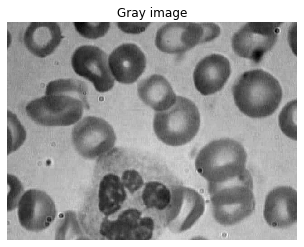

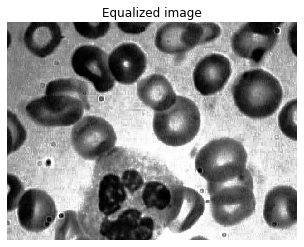

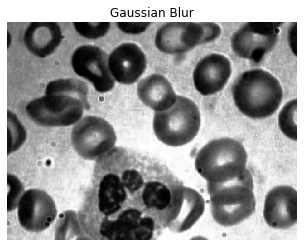

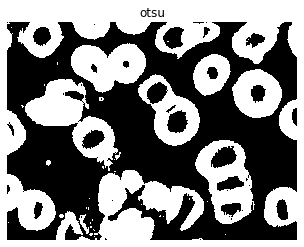

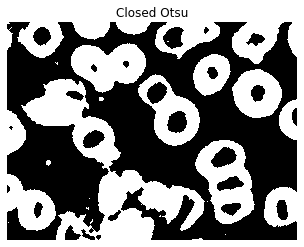

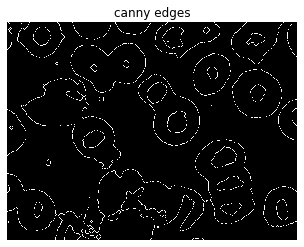

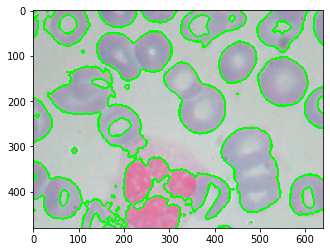

In [15]:
image_with_defined_edges_around_cells = find_cell_edges(image1)
image_contours = draw_contours_by_edges(image1, image_with_defined_edges_around_cells)

## Extract cell contour features

In [16]:
def write_properites(image_contours, csv_file_name):
    
    output_file = open(csv_file_name, "w")
    output_file.write(",".join(image_contours[0].contour_data.keys()) + "\n")

    for contour in image_contours:
        for value in contour.contour_data.values():
            output_file.write(str(value))
            output_file.write(",")
        output_file.write("\n")


In [17]:
write_properites(image_contours, "./data/contour_features.csv")

In [18]:
contours = pd.read_csv("./data/contour_features.csv", index_col = False)
contours.head()

,area,equivalent_diameter,enclosing_circle_center_x,enclosing_circle_center_y,enclosing_circle_diameter
0,0.0,0.000000,436,479,0
1,4.0,2.256758,420,478,24
2,84.0,10.341766,201,472,10
3,0.0,0.000000,482,467,2
4,29.5,6.128668,179,468,36


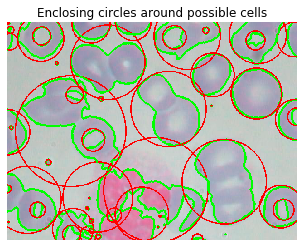

In [19]:
def filter_cell_contours(image, image_contours):
    
    for contour in image_contours:
        if (contour.contour_data["area"] > 0.1):
            cv2.drawContours(image, contour.contour, -1, (0, 255, 0), 3)
            cv2.circle(image,
                       (contour.contour_data["enclosing_circle_center_x"], 
                        contour.contour_data["enclosing_circle_center_y"]), 
                       int(contour.contour_data["enclosing_circle_diameter"]/2),
                       (255, 0, 0), 2)

    plot_image(image, "Enclosing circles around possible cells")
                                
filter_cell_contours(image1, image_contours)

## Visual tests with another different dataset?

Now, let's try with some different dataset and see whether the segmentation is at least a little bit robust to the colors and other specifications of the take images.
The other dataset is actually an online atlas - Hematology Atlas with a few images of blood smears in case of leukemias. 

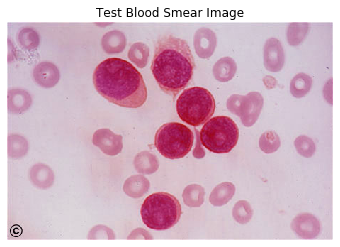

In [20]:
URL2 = "http://www.hematologyatlas.com/leukemias/"
PATH = "./data/hematology_atlas/"
test_image = read_image_by_url(URL2 + "1.jpg")
plot_image(test_image, "Test Blood Smear Image")

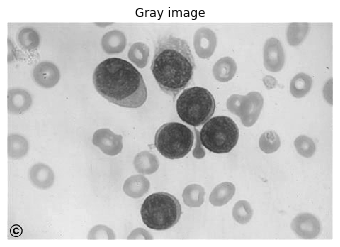

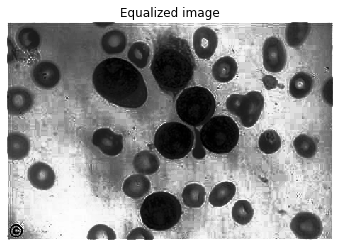

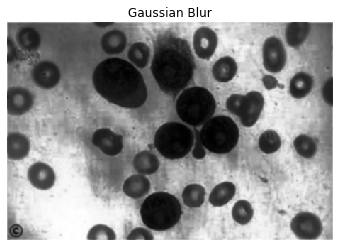

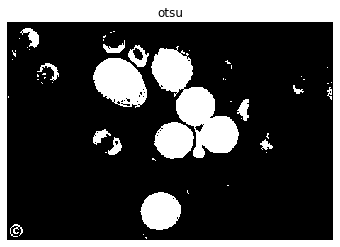

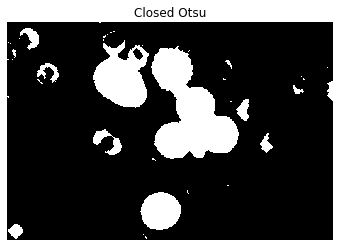

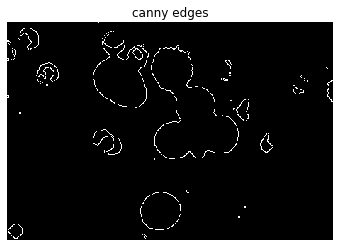

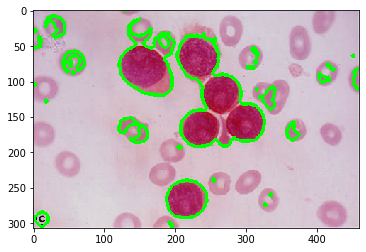

In [21]:
test_image_edges = find_cell_edges(test_image)
image_contours = draw_contours_by_edges(test_image, test_image_edges)